# Ex3. Siamese networks and zero-shot learning

The objective of the exercise was to train a vector embedding, visualize it and design a suitable classification scheme that uses the vector embedding. The dataset used was a 2 Gb subset of the ZooScanSet data set. 

Here is a short summary of my approach to deliver on this objective:
- I use transfer learning to train a classifier based on inception. It has an accuracy of about 87% on the validation set.
- I use this inception based classifier in a siamese network that I train on two different loss functions arriving at two different vector embeddings. The first loss function is the simple one presented in class, the second is a custom loss function I made to include prior knowledge on the taxonomy of the plankton in the embedding space.
- For classification I use 21-nearest neighbours on the vector embedding.

### Custom loss function
In this assignment I consider find two vector embeddings. One standard using the std_triplet_loss function, that is:
$$\mathcal{L} = \max(d_{pos}^2+ \alpha - d_{neg}^2, 0)$$,
where $d_{pos}$ and $d_{neg}$ is the distance between the positive and negative example and the anchor respectively, and $\alpha$ is some hyperparameter. The second embedding is found buy including the taxonomic distance in the loss function. In particular, it was found training a siamese neural network using the following loss function:
$$\mathcal{L} = d_{pos}+ \alpha|d_{true} - d_{neg}|$$,
where $d_{true}$ is the true distance between the anchor and the negative example as indicated by the taxonomic tree of the ZooScanSet dataset. As a distance metric I use the taxonomic distance as defined in: http://www.coastalwiki.org/wiki/Measurements_of_biodiversity, that is, the path between two leafes of a phylogenetic tree. This metric conforms to the triangle inequality. As the metric is only sensible when applied to taxonomic labels I do not include the egg__other and multiple__other classes when training and exploring this vector embedding.

### Notes on speeding up training time with redis.
I have identified reading image files of disk as a significant bottleneck in model training. As is, reading 2000 images takes about 45-50 seconds. I have addressed this by loading the images in a in-memory database called redis. It offers persistence by storing the entire database as a single file on the hard-drive, which apparently is much faster to load into memory than the image files seperately. This has significantly sped up training times.

### Notes on successful transfer learning
In this exercise I use the inception network as a base for my siamese network. In an exercise 1 I had problems getting good performance from this approach. This time I managed to make the model perform better on the dataset. I attribute this to two steps taken:
- I add a batch normalization layer before inception input layer.
- I use the tensorflow.keras implementation instead of the "default" keras implementation.
I strongly suspect that my problems with transfer learning in the earlier exercise is related to the problems discussed in the followng blog-post: https://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/ or some variation related to the problems discussed therein.


## Finding embeddings

I explored two different vector embeddings. Embedding 1 uses the loss function presented in class, embedding 2 uses the custom loss function presented above. Both embeddings are found by training siamese neural networks with the same architecture. The siamese neural network is based on an adaption of the inception model which has been customised using transfer learning.

So, the first thing I did was to train the inception model on the training dataset. After 25 epochs each training 20*1000 images I get an accuracy of about 87%.

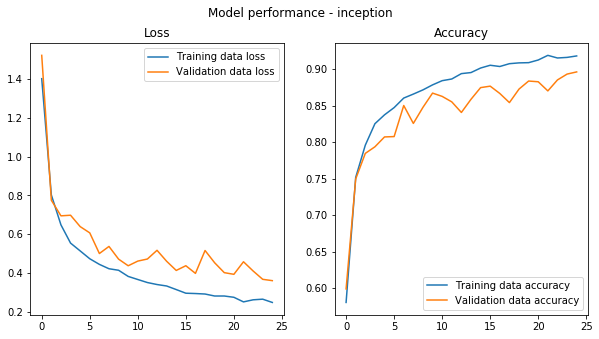

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("history_trained_"+C.base_model)

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training data loss')
    plt.plot(history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history['acc'], label='Training data accuracy')
    plt.plot(history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(C.base_model))
    plt.show()
plot_history(df)

I then use the trained inception model as a base in a siamese network. I train two variations of this network, each using one of the loss functions presented earlier. First let me present the functions used to visualize the embeddings:

In [1]:
from create_siamese_model import initialize_bitvector_model, model_path
import pandas as pd
from tensorflow.keras.models import load_model
from generators import Singlet
import config as C
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from read_hierarchy import taxonomic_grouping, taxonomic_path, taxonomic_ordering
import plotly.offline as pyo

import plotly.graph_objs as go

pyo.init_notebook_mode()


def make_taxonomic_distance_plot(X_2d, y):
    j = 13
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('afmhot')
    
    data = []
    for i in range(40):
        j, name = groups[i]
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(taxonomic_ordering(name))])
        obj = go.Scattergl(
            x=X_2d[y==i, 0],
            y= X_2d[y==i, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = "->".join(taxonomic_path(i)),
            showlegend=False,
            hoverinfo = 'text'
        )
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        hovermode="closest",
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    
    pyo.iplot(fig)

    
def make_uniqueness_plot(X_2d, y):
    j = 13
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('hsv', 40)
    
    data = []
    for i in range(40):
        j, name = groups[i]
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(i)])
        obj = go.Scattergl(
            x=X_2d[y==i, 0],
            y= X_2d[y==i, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = "->".join(taxonomic_path(i)),
            showlegend=False,
            hoverinfo = 'text'
        )
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        hovermode="closest",
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    
    pyo.iplot(fig)
    
def get_embedding(model, datagen, exclude):
    imgs = []
    labels = []
    embeddings = []
    while len(labels) <= len(datagen):
        X, y = datagen[0]
        if y in exclude:
            continue
        imgs.append(X)
        labels.append(y)
        embeddings.append(model.predict_on_batch(X))

    X = np.stack(embeddings).reshape((len(labels), model.output_shape[1]))
    y = np.asarray(labels).reshape((len(labels),))
     
    return X, y
    
    
def get_val_embedding(model, nrSamples = 1000, exclude=[]):
    nrSamples = 1000
    datagen = Singlet(batch_size=1, directory=C.val_dir, steps_per_epoch=nrSamples)
    return get_embedding(model, datagen, exclude)
    
def get_train_embedding(model,nrSamples = 1000, exclude=[]):
    nrSamples = 1000
    datagen = Singlet(batch_size=1, directory=C.val_dir, steps_per_epoch=nrSamples)
    return get_embedding(model, datagen, exclude)

tsne = TSNE(n_components=2, random_state=0, n_iter=3000)
mds = MDS(n_components=2)

First lets get some vector embedding data points by sampling the training data set:

In [2]:
bitvector_model = load_model(model_path("bitvector_"+C.base_model))
bitvector_X, bitvector_y = get_train_embedding(bitvector_model, 5000)

bitvector_X_2d_tsne = tsne.fit_transform(bitvector_X)
bitvector_X_2d_mds = mds.fit_transform(bitvector_X.astype(np.float64))

Instructions for updating:
Colocations handled automatically by placer.


Now, lets use 2 component tsne for dimensionality reduction, and see how well the classes has been clustered in the embedding space. See from the following figure that when I use the std_triplet_loss function I get an embedding that produces clusters that are more or less unique for each of the classes.

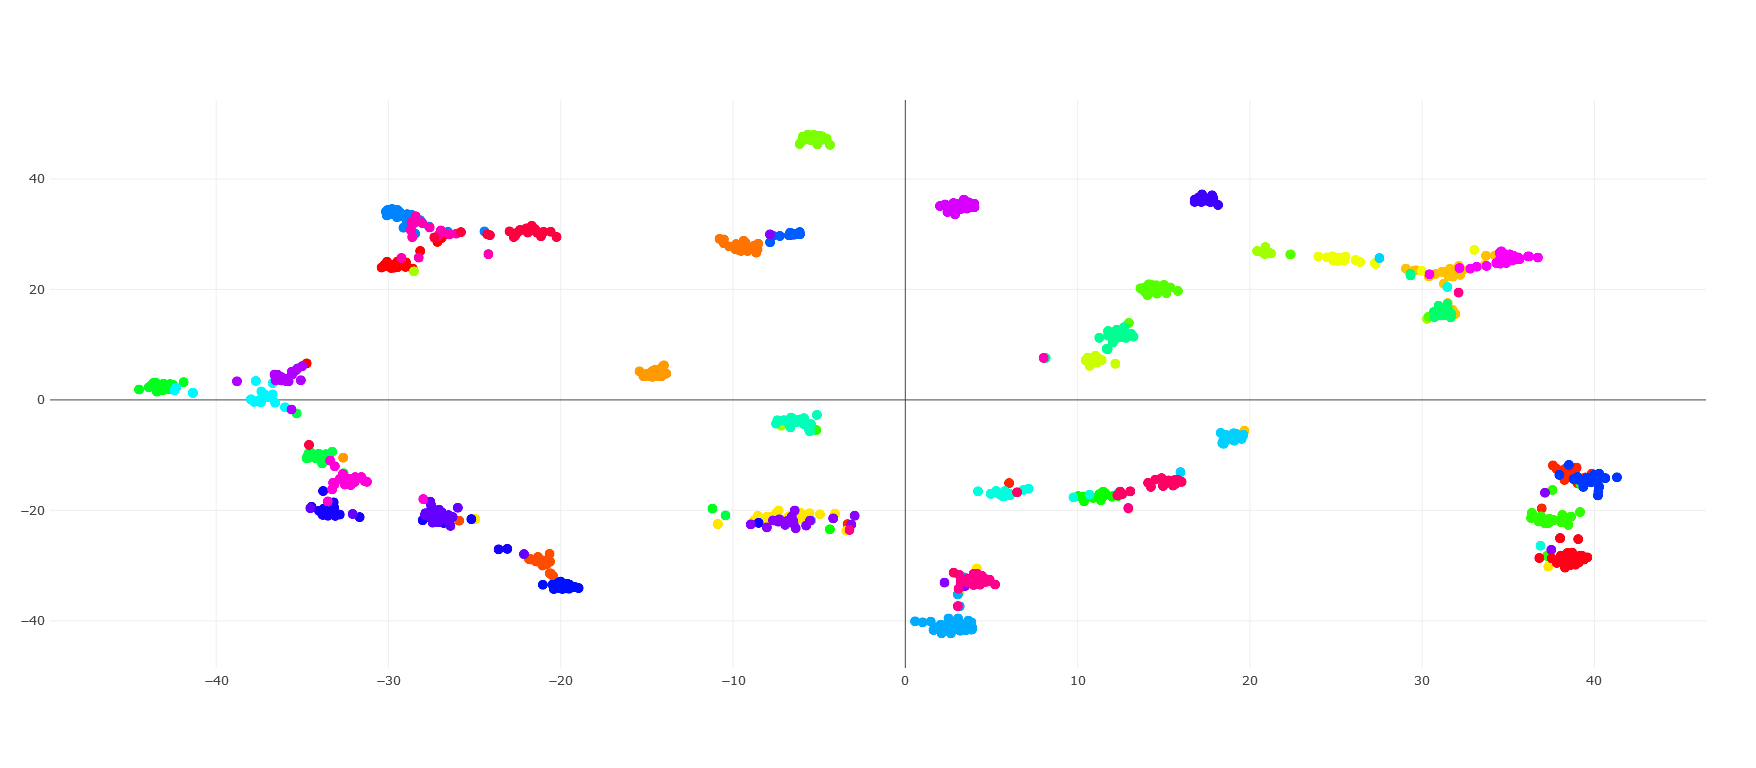

In [3]:
make_uniqueness_plot(bitvector_X_2d_tsne, bitvector_y)

Now, lets use an MDS embedding for dimensionality reduction. This algorithm preserves the distance between points. I am curious if the the standard loss function will map taxonomically close classes next to each other in the embedding space. To test this I order the features by taxonomic distance to the root, and see if there is a nice pattern to be seen in the a scatter plot using the MDS embedding. From the following plot we do not see any indication that the taxonomic distance between the classes is preserved in the embedding found using the standard loss function:

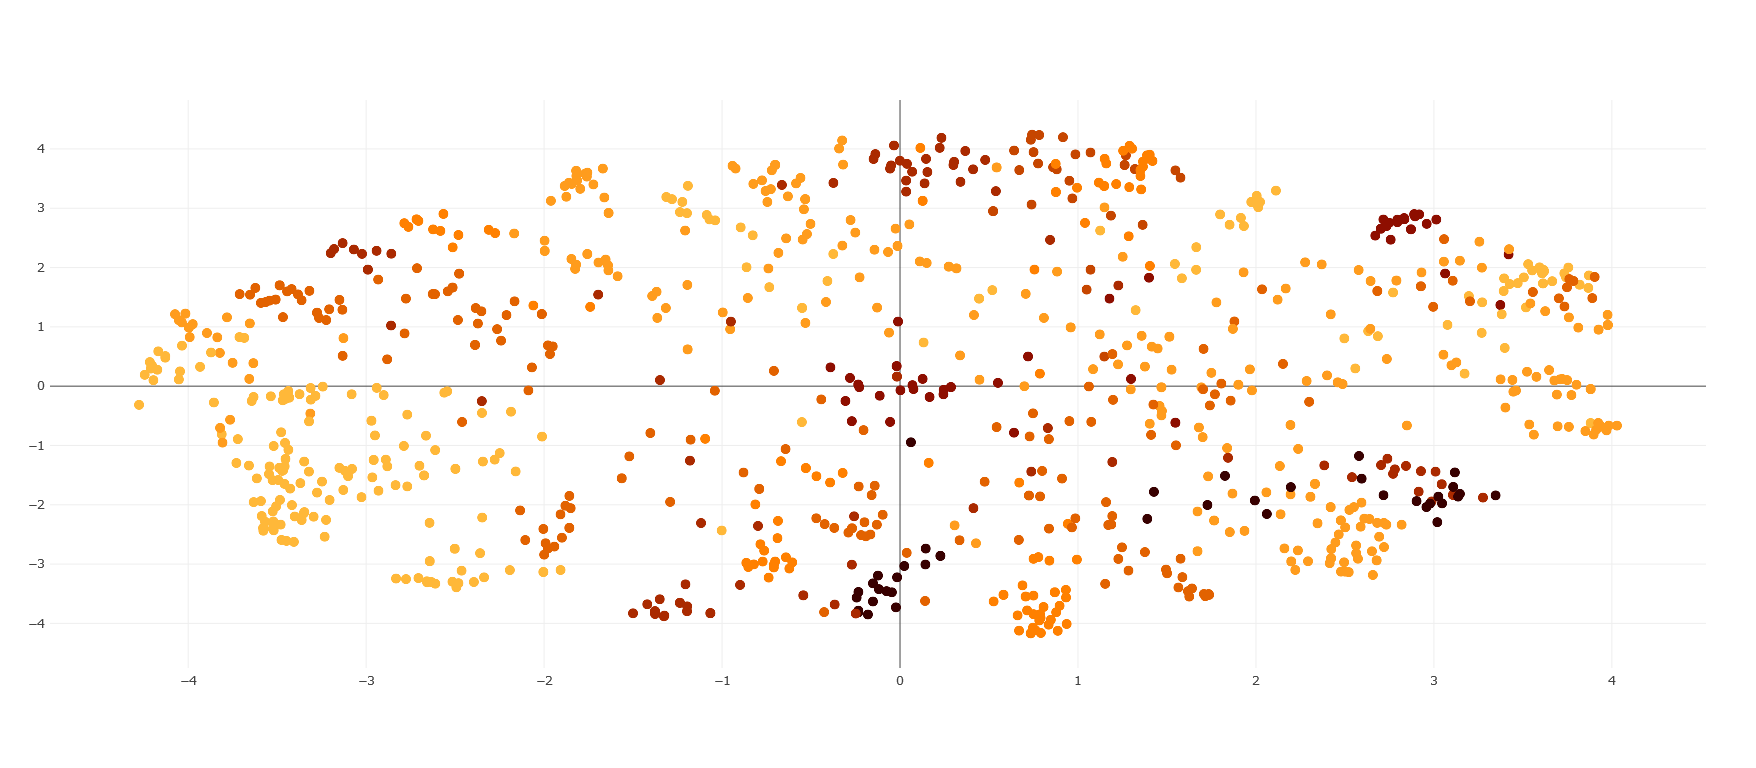

In [4]:
make_taxonomic_distance_plot(bitvector_X_2d_mds, bitvector_y)

In fact it is clear from the following plot that most features in the embedding space are equidistant, with a mean distance that equals the $\alpha$ parameter set during training. 

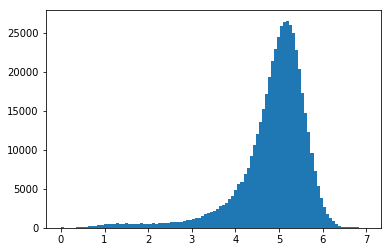

In [5]:
distances = []

for i in range(len(bitvector_X)-1):
    for j in range(i+1, len(bitvector_X)):
        distances.append(np.linalg.norm(bitvector_X[i]-bitvector_X[j]))
plt.hist(distances, bins=100)
plt.show()

From this I tentatively conclude that the distance in the embedding space found using the standard loss function is informative on whether two instances belong too the same class, but not so much on how different they are taxonomically.

Now lets consider embedding found when using the loss function that takes advantag of the taxonomic distance between the classes. We see from the following plot that it to produces clusters with largely one class, although it is clear that this is not as unique as that produced by the standard loss function:

In [6]:
hierarchy_bitvector_model = load_model(model_path("hierachy_bitvector_"+C.base_model))
hierachy_bitvector_X, hierachy_bitvector_y = get_train_embedding(hierarchy_bitvector_model, 5000, exclude=[C.plankton_str2int["egg__other"], C.plankton_str2int["multiple__other"]])

hierachy_bitvector_X_2d_tsne = tsne.fit_transform(hierachy_bitvector_X)
hierachy_bitvector_X_2d_mds = mds.fit_transform(hierachy_bitvector_X.astype(np.float64))

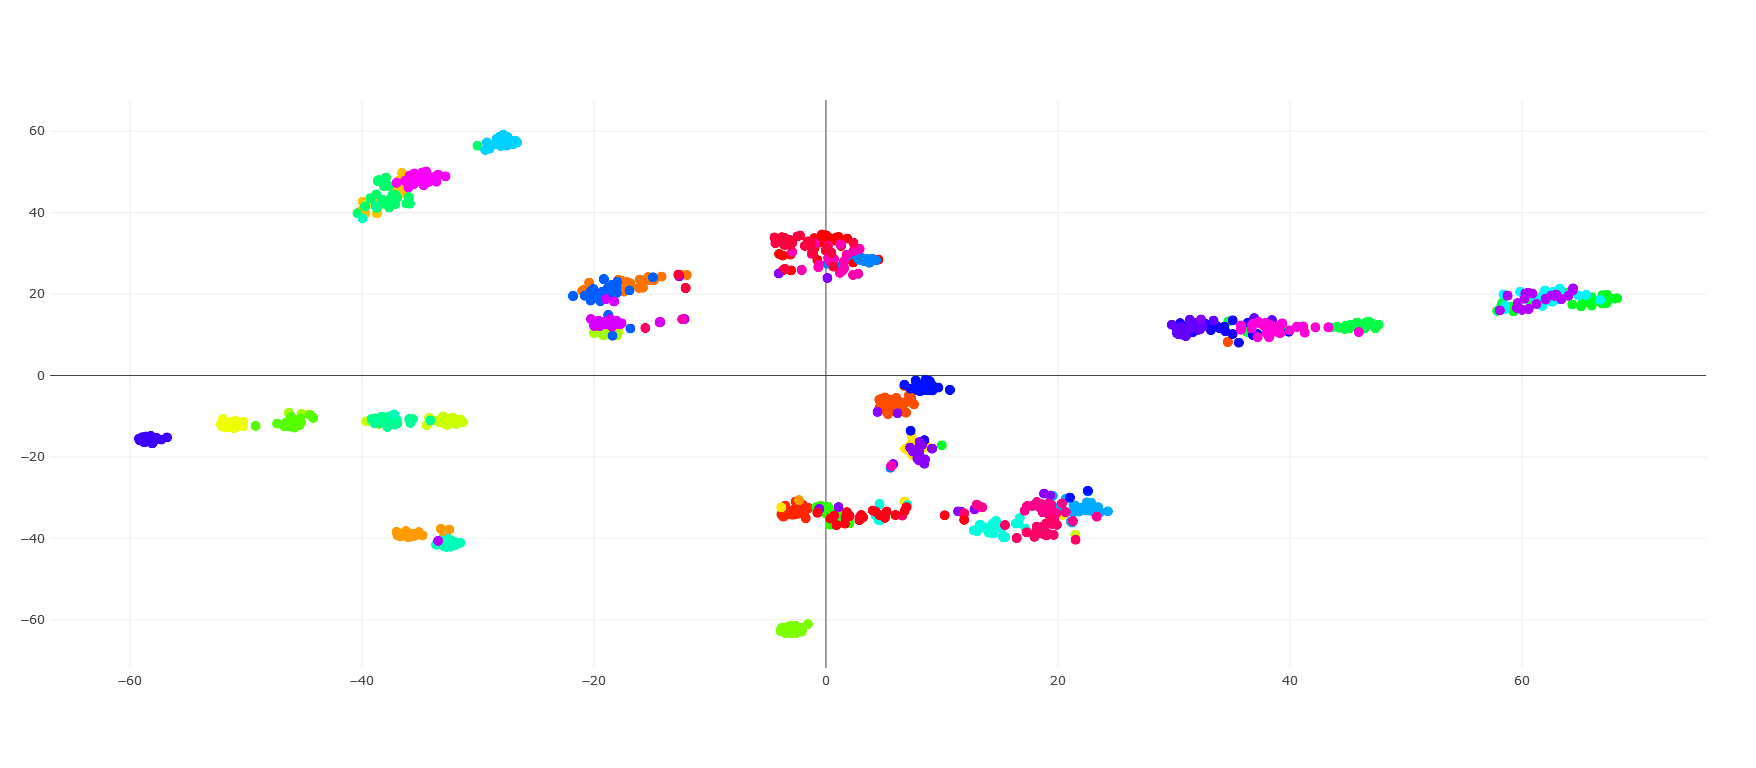

In [7]:
make_uniqueness_plot(hierachy_bitvector_X_2d_tsne, hierachy_bitvector_y)

Now, the second loss function was designed to imbue the embedding space with some taxonomic a priori knowledge. However the following isomap plot does does not reflect any such structure.

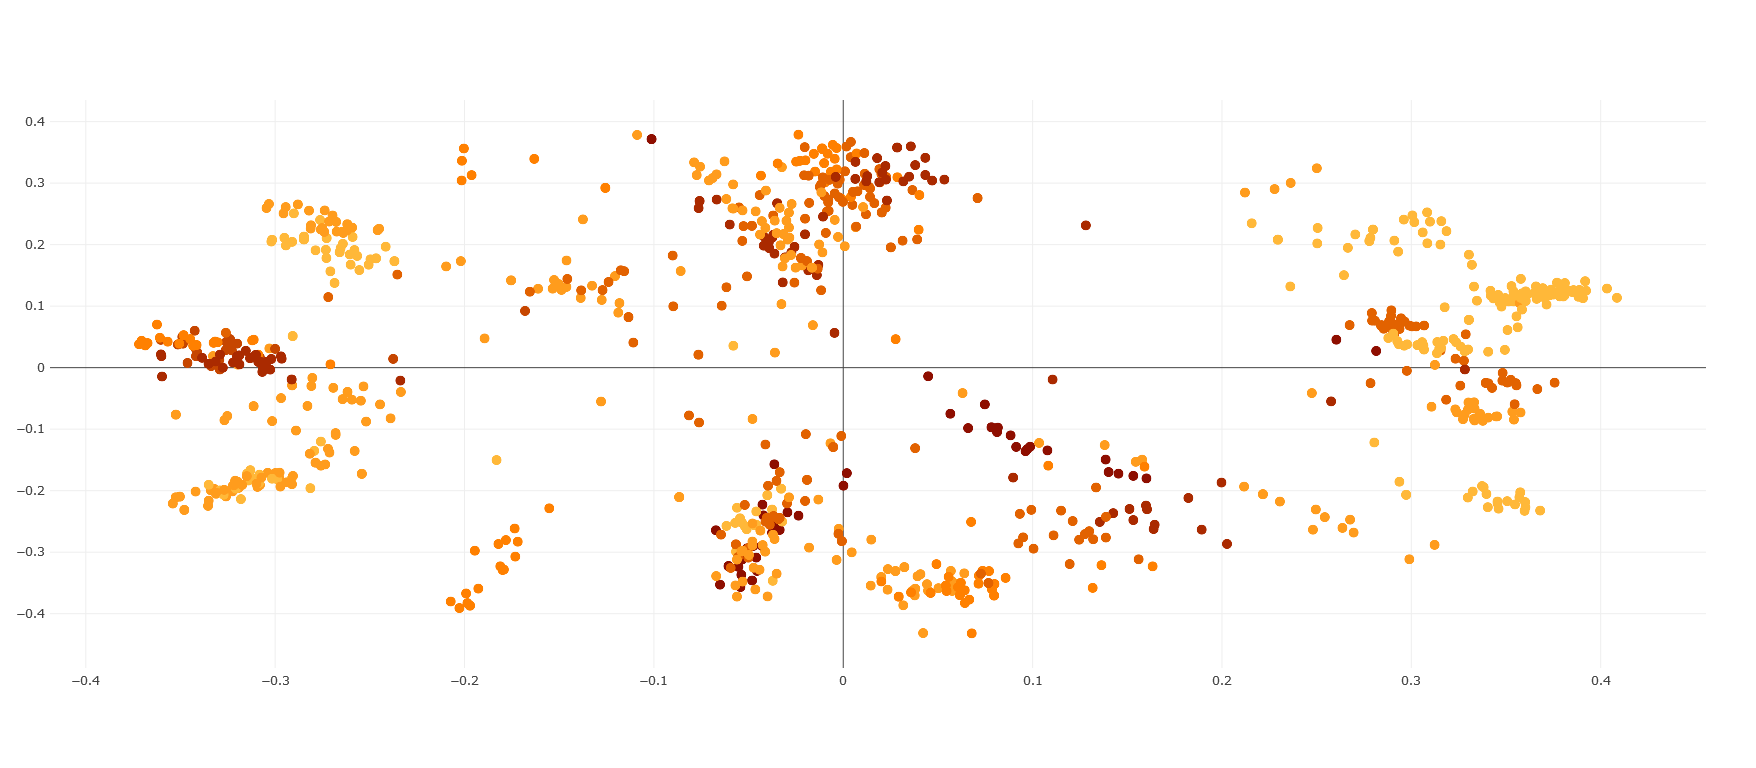

In [21]:
make_taxonomic_distance_plot(hierachy_bitvector_X_2d_mds, hierachy_bitvector_y)

The following plot demonstrates that there is more variation in the distance between the points of the embedding space. To test if the distances of the embedding space has taxonomic significance it is best to test with validation data.

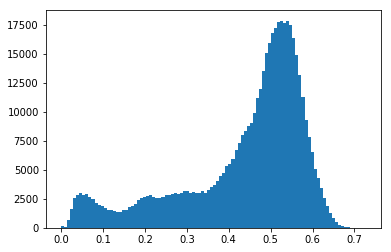

In [9]:
distances = []

for i in range(len(hierachy_bitvector_X)-1):
    for j in range(i+1, len(hierachy_bitvector_X)):
        distances.append(np.linalg.norm(hierachy_bitvector_X[i]-hierachy_bitvector_X[j]))
plt.hist(distances, bins=100)
plt.show()

## Classifier
Lets first consider the first embedding. First lets train a classifier using the training data:

In [10]:
from sklearn.neighbors import KNeighborsClassifier
embedding_1_classifier = KNeighborsClassifier(n_neighbors=21).fit(bitvector_X, bitvector_y)

Now lets generate som test data to evaluate the classifier performance:

In [11]:
val_bitvector_X, val_bitvector_y = get_val_embedding(bitvector_model, 2000)
embedding_1_classifier.score(val_bitvector_X, val_bitvector_y)

0.8701298701298701

Lets visualize the model performance using a confusion matrix:

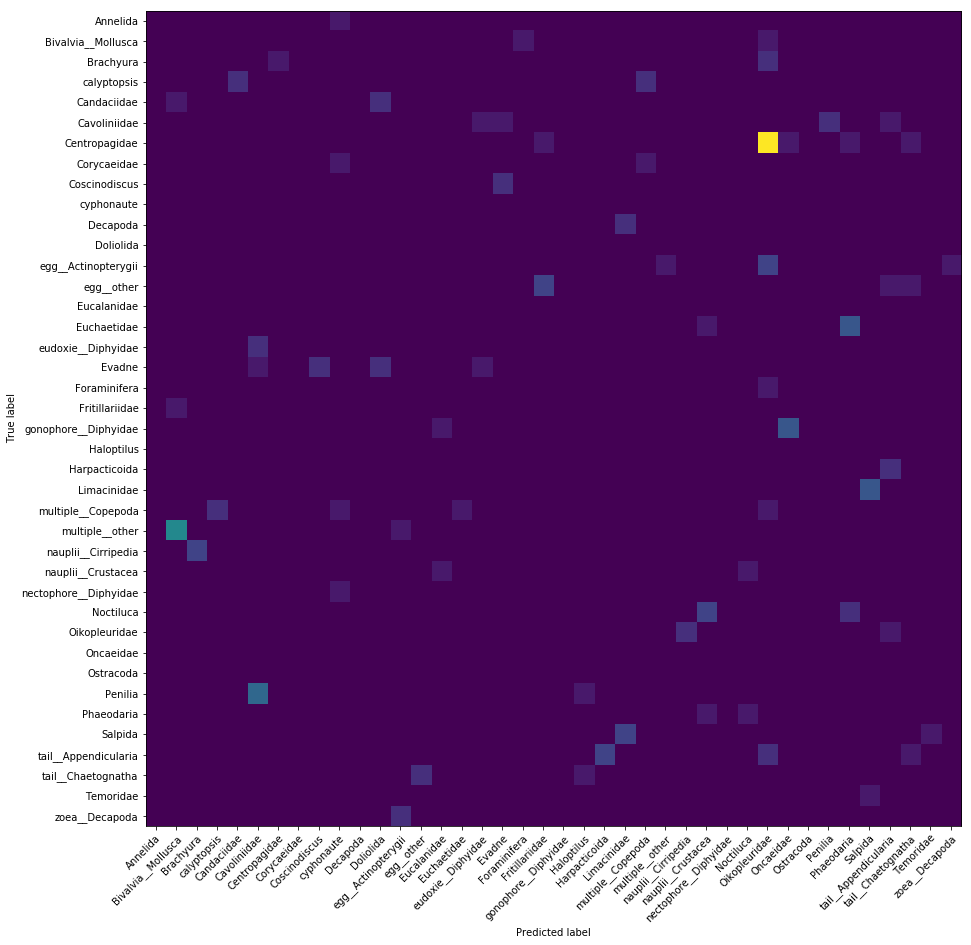

In [14]:
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(embedding_1_classifier.predict(val_bitvector_X), val_bitvector_y)

classes = [C.plankton_int2str[i] for i in range(40)]

for i in range(40):
    cm [i,i] = 0

fig, ax = plt.subplots(figsize=(15,15))    
ax.imshow(cm)#
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()

Lets repeat for the second embedding. Lets train a classifier using training data:

In [18]:
from sklearn.neighbors import KNeighborsClassifier
embedding_2_classifier = KNeighborsClassifier(n_neighbors=21).fit(hierachy_bitvector_X, hierachy_bitvector_y)

Now lets generate som test data to evaluate the classifier performance:

In [19]:
val_hierachy_bitvector_X, val_hierachy_bitvector_y = get_val_embedding(hierarchy_bitvector_model, 2000, exclude=[C.plankton_str2int["egg__other"], C.plankton_str2int["multiple__other"]])
embedding_2_classifier.score(val_hierachy_bitvector_X, val_hierachy_bitvector_y)

0.7512487512487512

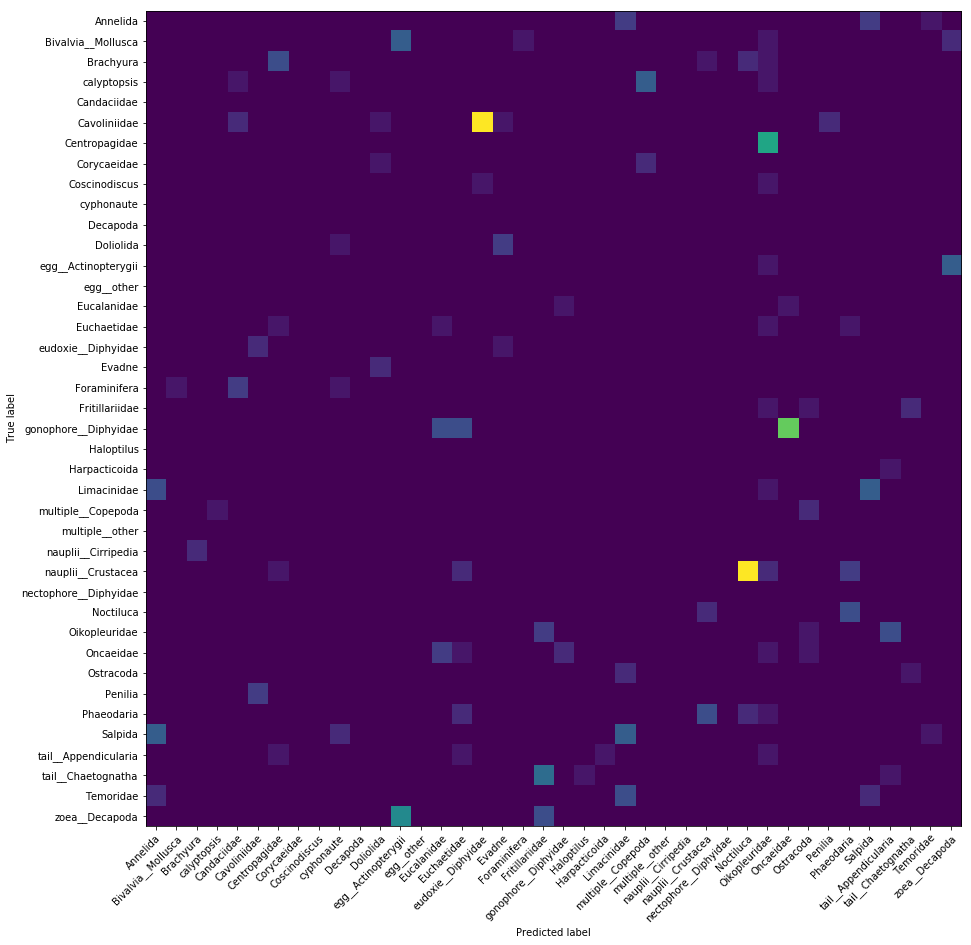

In [17]:
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(embedding_2_classifier.predict(val_hierachy_bitvector_X), val_hierachy_bitvector_y, range(40))

classes = [C.plankton_int2str[i] for i in range(40)]

for i in range(40):
    cm [i,i] = 0

fig, ax = plt.subplots(figsize=(15,15))    
ax.imshow(cm)#
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()

Conclusion:
